In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lap_data = pd.read_csv("./datasets/lap_data/Bahrain_Grand_Prix.csv")
telem_data = pd.read_csv("./datasets/telemetry_data/Bahrain_time_series.csv")

In [30]:
driver_id = "VER"

### Lap data analysis

In [32]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
print(driver_race_time)

01:31:44.741999


### Telemetry data analysis

In [53]:
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id]
driver_telemetry.head(n=10)

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Time,SessionTime,DriverAhead,DistanceToDriverAhead,X,Y,LapNumber,TrackStatus,DriverNumber,Driver,ID
0,2024-03-02 15:03:42.342,9973,0,1,15,True,1,0 days 00:00:00,0 days 00:59:59.911000,NaN,0.133333,-279.998940,3550.093709,1.0,12,1,VER,0
1,2024-03-02 15:03:42.390,9963,0,1,15,True,1,0 days 00:00:00.048000,0 days 00:59:59.959000,NaN,0.133333,-279.999056,3550.083823,1.0,12,1,VER,1
2,2024-03-02 15:03:42.460,9859,0,1,15,True,1,0 days 00:00:00.118000,0 days 01:00:00.029000,NaN,0.133333,-280.000000,3550.000000,1.0,12,1,VER,2
3,2024-03-02 15:03:42.630,9755,0,1,15,True,1,0 days 00:00:00.288000,0 days 01:00:00.199000,3.0,0.133333,-280.004222,3549.625202,1.0,12,1,VER,3
4,2024-03-02 15:03:42.700,9125,1,1,15,True,1,0 days 00:00:00.358000,0 days 01:00:00.269000,3.0,0.066667,-280.000000,3550.000000,1.0,12,1,VER,4
5,2024-03-02 15:03:42.870,8495,3,1,15,False,1,0 days 00:00:00.528000,0 days 01:00:00.439000,63.0,0.000000,-279.965389,3553.072657,1.0,12,1,VER,5
6,2024-03-02 15:03:43.040,7655,7,1,15,False,1,0 days 00:00:00.698000,0 days 01:00:00.609000,63.0,0.000000,-280.000000,3558.000000,1.0,12,1,VER,6
7,2024-03-02 15:03:43.110,6815,11,1,15,False,1,0 days 00:00:00.768000,0 days 01:00:00.679000,4.0,0.000000,-280.064521,3560.216660,1.0,12,1,VER,7
8,2024-03-02 15:03:43.270,5695,17,1,15,False,1,0 days 00:00:00.928000,0 days 01:00:00.839000,4.0,0.000000,-280.314612,3565.704150,1.0,12,1,VER,8
9,2024-03-02 15:03:43.460,5041,21,1,16,False,1,0 days 00:00:01.118000,0 days 01:00:01.029000,4.0,0.000000,-280.000000,3574.000000,1.0,12,1,VER,9


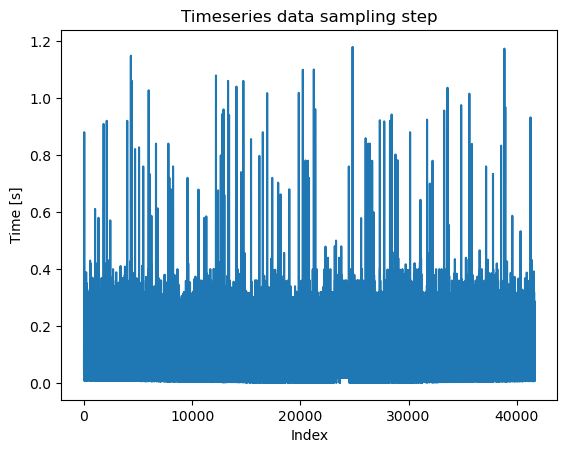

In [ ]:
# Load driver speed timeseries data
driver_speed = pd.Series(driver_telemetry["Speed"].values.astype(float), pd.to_datetime(driver_telemetry["Date"]))

# Check data sampling step
DT = (driver_speed.index[1:] - driver_speed.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_speed.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

# Resample data on 1 second interval
downsampled_speed = driver_speed.resample("1s").mean()

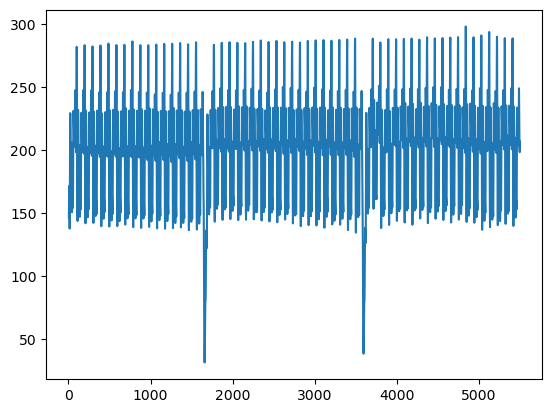

In [159]:
# Calculate and display speed rolling mean
rm_speed = downsampled_speed.rolling(window=10, center=True).mean()
plt.plot(np.arange(len(rm_speed)), rm_speed.values)

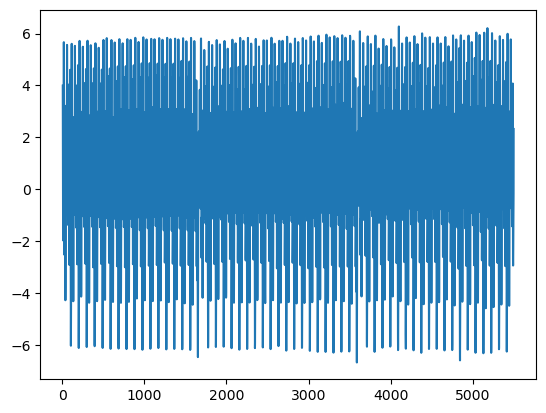

In [166]:
# Convertion from km/h to m/s
downsampled_speed_ms = pd.Series(downsampled_speed.values / 3.6)

# Calculate acceleration (first derivative)
dt = 1.0
acceleration = (downsampled_speed_ms.values[1:] - downsampled_speed_ms.values[:-1]) / dt
acceleration = pd.Series(acceleration)

rm_accel = acceleration.rolling(window=10, center=True).mean()
plt.plot(np.arange(len(rm_accel)), rm_accel)